# POC-Turtle-4: Grammar Learning | 2018-03-14
This is a continuation of proof-of-concept (POC) experiments in unsupervised language learning (ULL), the OpenCog project hosted on [GitHub](https://github.com/opencog/language-learning/tree/master/notebooks). 
The previous 3 notebooks on word category learning are shared as [static html pages](http://88.99.210.144/data/clustering_2018/html/):  
- [POC-Turtle-1-Clustering-Words](http://88.99.210.144/data/clustering_2018/html/POC-Turtle-1-Clustering-Words.html)  
- [POC-Turtle-2-Singular-Values](http://88.99.210.144/data/clustering_2018/html/POC-Turtle-2-Singular-Values.html)  
- [POC-Turtle-3-Disjuncts](http://88.99.210.144/data/clustering_2018/html/POC-Turtle-3-Disjuncts.html)  

This notebook is the second update of the notebook first shared 2018-02-24.  
Link Grammar files are shared via [http://88.99.210.144/data/clustering_2018/POC-Turtle-4-2018-03-14/](http://88.99.210.144/data/clustering_2018/POC-Turtle-4-2018-03-14/).

In [1]:
import os, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path: sys.path.append(module_path)
from src.utl.utl import UTC, round3, round4, round5
from src.space.turtle import dmb_parser, wps2vec #, wps2connectors
from src.clustering.kmeans import cluster_words_kmeans
from src.clustering.similarity import cluster_similarity
from src.utl.turtle import html_table, plot2d
print(UTC(), ':: module_path:', module_path)

2018-03-15 08:42:31 UTC :: module_path: /home/obaskov/language-learning


## 4.1 Settings, parameters, data.

In [2]:
prj_dir = '../output/Turtle-4-2018-03-14/'  # project directory 
prefix = ''     # all project files will start with this prefix
verbose = 'max' # printed comments: 'none', 'min', 'max'
log = {'project': 'POC-Turtle-4+: Grammar Learner update'}

if not os.path.exists(prj_dir):
    os.makedirs(prj_dir)
    print('Project directory created:', module_path + prj_dir[2:])
else: print('Project directory', module_path + prj_dir[2:], 'exists')

Project directory /home/obaskov/language-learning/output/Turtle-4-2018-03-14/ exists


### Parameters
Most learning parameters are entered manually based on numerical criteria that can be set to auto definition after tests on bigger corpora.
- word space metrics -- PMI (others not tested);
- word vector space dimensionality reduction algorithm -- SVD (others not tested);
- word space dimensionality -- manual / auto (4.2.1),
 - word space dimensions choice criteria -- singular values (SVD);
- clustering algorithm -- K-Means (others not tested);
- number of clusters -- manual / auto (4.2.2),
 - number of clusters choice criteria -- Silhouette index (others not tested);
- number of agglomerated clusters - manual choice based on cosine similarity (4.2.3).

### Data: simplified ["Turtle language" corpus](http://88.99.210.144/data/clustering_2018/input_data/poc-turtle-sentences.txt)

In [3]:
input_file = '../data/poc-turtle-sentences.txt'
if os.path.isfile(input_file):
    print('Data file:', module_path + input_file[2:],)
    log.update({'input_file': module_path + input_file[2:]})
    if verbose == 'max':
        print('- "Turtle" language corpus:')
        with open(input_file, 'r') as f: 
            lines = f.read().splitlines()
        for i,line in enumerate(lines): 
            if len(line) > 0: print(str(i+1)+'. '+line)    
else: print('No data file', module_path + input_file[2:])

Data file: /home/obaskov/language-learning/data/poc-turtle-sentences.txt
- "Turtle" language corpus:
1. tuna isa fish.
2. herring isa fish.
3. tuna has fin.
4. herring has fin.
5. parrot isa bird.
6. eagle isa bird.
7. parrot has wing.
8. eagle has wing.
9. fin isa extremity.
10. wing isa extremity.
11. fin has scale.
12. wing has feather.


In [4]:
# We use LEFT-WALL token instead of ###LEFT-WALL### and treat periods as tokens
wps = dmb_parser(input_file, lw='LEFT-WALL', dot=True, verbose='none')
wps.tail(4)  # Last 4 entries show the last sentence parsed:

,word1,word2,count
44,LEFT-WALL,wing,1
45,wing,has,1
46,has,feather,1
47,feather,.,1


In [5]:
# wps  # uncomment this line to see the full 48 word pairs DataFrame

## 4.2 Category learner.
Category learner learns word categories by clustering similar words.  
Then we can learn (grammatic) relations between word categories.
### 4.2.1 Word vector space
We create word-connector space as described in [POC-Turtle-1-Clustering-Words](http://88.99.210.144/data/clustering_2018/html/POC-Turtle-1-Clustering-Words.html) and define optimal vector space dimensionality with singular values as described in [POC-Turtle-2-Singular-Values](http://88.99.210.144/data/clustering_2018/html/POC-Turtle-2-Singular-Values.html).

Singular values: 5.65, 5.29, 4.95, 4.67, 4.59, 3.49, 3.45, 0.19


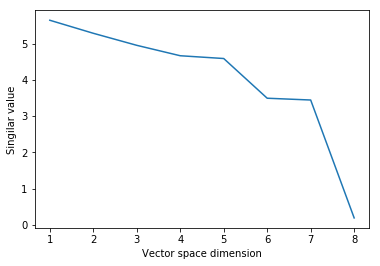

In [6]:
# Check singular values 
path = module_path + prj_dir[2:]        # path to store vectors
tmpath = path  # module_path + '/tmp/'  # path for temporary files
dim = 12       # dimensionality
vdf, sv, res1 = wps2vec(wps, path, tmpath, dim)
print('Singular values:', ', '.join(str(round(x,2)) for x in sv))
plt.plot(range(1,len(sv)+1), sv)
plt.xlabel('Vector space dimension')
plt.ylabel('Singilar value')
plt.show()

Singular values show that:  
- we can't create a wordspace with more tan 8 dimensions for a given dataset, 
- there's no reason to use more than 7 dimensions - the 8th dimension singular value is too small. 

In [7]:
# Create 7-dimension word vector space
vdf, sv, res2 = wps2vec(wps, path, tmpath, dim=7)
log.update(res2)
vdf.applymap(round3).sort_values(by=[1,2], ascending=[True,True])

,word,1,2,3,4,5,6,7
8,has,-0.729,0.000,-0.273,0.000,0.016,0.000,-0.628
10,isa,-0.688,0.000,-0.180,0.000,0.436,0.000,0.551
0,.,-0.402,0.000,0.896,0.000,-0.188,0.000,0.010
1,LEFT-WALL,-0.258,0.000,-0.305,0.000,-0.880,0.000,0.257
2,bird,0.000,0.312,0.000,-0.776,0.000,0.548,0.000
4,extremity,0.000,0.312,0.000,-0.776,0.000,0.548,0.000
7,fish,0.000,0.312,0.000,-0.776,0.000,0.548,0.000
5,feather,0.000,0.421,0.000,-0.551,0.000,-0.720,0.000
12,scale,0.000,0.421,0.000,-0.551,0.000,-0.720,0.000
3,eagle,0.000,0.835,0.000,0.501,0.000,0.228,0.000


The words are sorted ascending by axes 1 and 2. 4 noun clusters are visible on the axis 2 - words with same values for both axes 1 and 2. We can treat the first four words as 1-word clusters and say we see 8 "natural" clusters in the word space. However, let's check the optimal number of clusters with silhouette index.

### 4.2.2 Clustering words.

Silhouette index in a range of cluster numbers


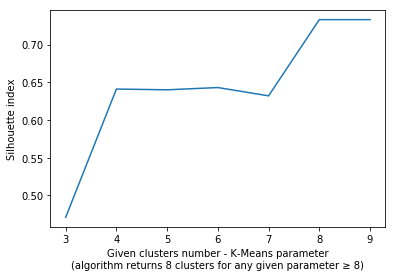

N,NR,Silhouette,Inertia,Cluster words
3,3,0.471,5.806,. LEFT-WALL eagle has herring isa parrot tuna || bird extremity fish || feather fin scale wing
4,4,0.641,3.212,. LEFT-WALL has isa || bird extremity fish || feather fin scale wing || eagle herring parrot tuna
5,5,0.64,2.2,LEFT-WALL has isa || . || bird extremity fish || feather fin scale wing || eagle herring parrot tuna
6,6,0.643,1.186,has isa || . || LEFT-WALL || bird extremity fish || feather fin scale wing || eagle herring parrot tuna
7,7,0.632,0.399,has || isa || . || LEFT-WALL || bird extremity fish || feather fin scale wing || eagle herring parrot tuna
8,8,0.733,0.0,has || isa || . || LEFT-WALL || bird extremity fish || feather scale || eagle herring parrot tuna || fin wing
9,8,0.733,0.0,has || isa || . || LEFT-WALL || bird extremity fish || feather scale || eagle herring parrot tuna || fin wing


In [8]:
# Find optimal number of clusters: max Silhouette index
sil_range = pd.DataFrame(
    columns=['Np','Nc','Silhouette','Inertia', 'Cluster words'])
table = [['N', 'NR', 'Silhouette', 'Inertia', 'Cluster words']]
for i,j in enumerate(range(3,10)):
    cdf, silhouette, inertia = cluster_words_kmeans(vdf, j)
    sil_range.loc[i] = [j, len(cdf), round(silhouette,3), \
        round(inertia,3), cdf['cluster_words'].tolist()]
    table.append([j, len(cdf), round(silhouette,3), round(inertia,3), \
        ' || '.join(' '.join(str(word) for word in cluster) \
                    for cluster in cdf['cluster_words'].tolist())])
sil_range[['Np','Nc']] = sil_range[['Np','Nc']].astype(int)
print('Silhouette index in a range of cluster numbers')
plt.plot(sil_range['Np'], sil_range['Silhouette'])
plt.xlabel('Given clusters number - K-Means parameter\n' + \
           '(algorithm returns 8 clusters for any given parameter ≥ 8)')
plt.ylabel('Silhouette index')
plt.show()
display(html_table(table))

In [9]:
n = 8  # Number of clusters
clusters, silhouette, inertia = cluster_words_kmeans(vdf, n)
clusters.applymap(round3)

,cluster,cluster_words,1,2,3,4,5,6,7
1,C01,[has],-0.729,0.000,-0.273,0.000,0.016,0.000,-0.628
2,C02,[isa],-0.688,0.000,-0.180,0.000,0.436,0.000,0.551
3,C03,[.],-0.402,0.000,0.896,0.000,-0.188,0.000,0.010
4,C04,[LEFT-WALL],-0.258,0.000,-0.305,0.000,-0.880,0.000,0.257
5,C05,"[bird, extremity, fish]",0.000,0.312,0.000,-0.776,0.000,0.548,0.000
6,C06,"[feather, scale]",0.000,0.421,0.000,-0.551,0.000,-0.720,0.000
7,C07,"[eagle, herring, parrot, tuna]",0.000,0.835,0.000,0.501,0.000,0.228,0.000
8,C08,"[fin, wing]",0.000,0.848,0.000,-0.133,0.000,-0.514,0.000


Cluster words in vector space, axes 1 and 2


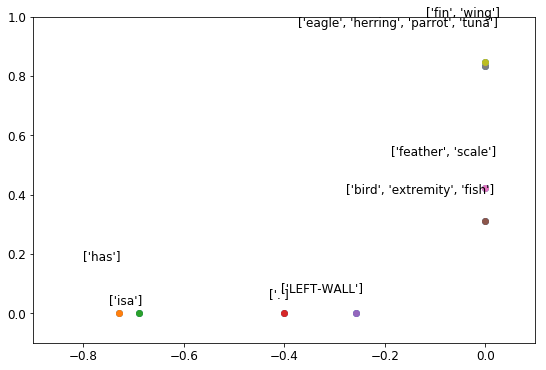

In [10]:
plot2d(1, 2, clusters, 'cluster_words', 12)

### 4.2.3 Cluster Similarity.

Cluster similarities: absolute values > 0.01:


,c1,c2,similarity,c1_words,c2_words
26,C06,C08,0.800625,"[feather, scale]","[fin, wing]"
27,C07,C08,0.523843,"[eagle, herring, parrot, tuna]","[fin, wing]"
0,C01,C02,0.212294,[has],[isa]
22,C05,C06,0.165243,"[bird, extremity, fish]","[feather, scale]"
2,C01,C04,0.094945,[has],[LEFT-WALL]
24,C05,C08,0.087112,"[bird, extremity, fish]","[fin, wing]"
1,C01,C03,0.038765,[has],[.]
7,C02,C03,0.038038,[isa],[.]


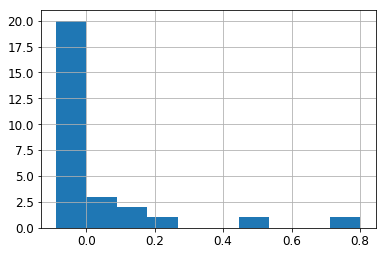

In [11]:
sim_df, res3 = cluster_similarity(clusters, 'max')
log.update(res3)
count, division = np.histogram(sim_df['similarity'])
sim_df['similarity'].hist(bins=division)
print('Cluster similarities: absolute values > 0.01:')
sim_df.sort_values(by='similarity', ascending=False).loc[(sim_df['similarity']) > 0.01]

So we have got 2 word categories -- nouns and verbs, and two separate punctuation marks - period and #LW#. Now we can explore relations between clusters and word categories with an objective to learn grammar rules.

## 4.3 Learning grammar exploring links between word clusters.
The goal of POS-Turtle experiments is to prove the possibility of unsupervised language learning by finding similarities between words ("Category Learner" component) and relations between word categories. We suggest that the latter can extract grammar rules from text. Let's start getting statistics on relations between word clusters.  
First we try to learn grammar after learning word categories, separating the Grammar Learner from the Category Learner. 
Later we may want (and find feasible) to enhance both category and grammar learning via updating category learner using knowledge obtained during grammar learning...

In [12]:
clusters.applymap(round3)

,cluster,cluster_words,1,2,3,4,5,6,7
1,C01,[has],-0.729,0.000,-0.273,0.000,0.016,0.000,-0.628
2,C02,[isa],-0.688,0.000,-0.180,0.000,0.436,0.000,0.551
3,C03,[.],-0.402,0.000,0.896,0.000,-0.188,0.000,0.010
4,C04,[LEFT-WALL],-0.258,0.000,-0.305,0.000,-0.880,0.000,0.257
5,C05,"[bird, extremity, fish]",0.000,0.312,0.000,-0.776,0.000,0.548,0.000
6,C06,"[feather, scale]",0.000,0.421,0.000,-0.551,0.000,-0.720,0.000
7,C07,"[eagle, herring, parrot, tuna]",0.000,0.835,0.000,0.501,0.000,0.228,0.000
8,C08,"[fin, wing]",0.000,0.848,0.000,-0.133,0.000,-0.514,0.000


In [13]:
# wps.tail(4)  # uncomment to check 4 last entries of the parsed word pairs dataset

### 4.3.1 "First take": 8 clusters as-is, "single disjuncts"
"Single disjuncts" - the simpliest approach: treat kinks (linked word pairs) as disjuncts,  
avoid parsing sentences to obtain disjuncts as pairs (sets) of links for each word. 

In [14]:
from src.space.turtle import wps2links
links = wps2links(wps, clusters)
links.tail(4)

,word1,word2,count,c1,c2,link
44,LEFT-WALL,wing,1,C04,C08,C04C08
45,wing,has,1,C08,C01,C08C01
46,has,feather,1,C01,C06,C01C06
47,feather,.,1,C06,C03,C06C03


In [15]:
from src.clustering.turtle import cluster_links_matrix
cluster_links_matrix(clusters, links)

,cluster,cluster_words,C01,C02,C03,C04,C05,C06,C07,C08
1,C01,[has],0,0,0,0,0,2,0,4
2,C02,[isa],0,0,0,0,6,0,0,0
3,C03,[.],0,0,0,0,0,0,0,0
4,C04,[LEFT-WALL],0,0,0,0,0,0,8,4
5,C05,"[bird, extremity, fish]",0,0,6,0,0,0,0,0
6,C06,"[feather, scale]",0,0,2,0,0,0,0,0
7,C07,"[eagle, herring, parrot, tuna]",4,4,0,0,0,0,0,0
8,C08,"[fin, wing]",2,2,4,0,0,0,0,0


In [16]:
from src.clustering.turtle import cluster_links
linked_clusters = cluster_links(clusters, links)
display(html_table([['Link', '1st linked word cluster', '2nd linked word cluster']] \
    + [[x[0]]+x[1] for x in list(linked_clusters.items())]))

Link,1st linked word cluster,2nd linked word cluster
C01C06,['has'],"['feather', 'scale']"
C01C08,['has'],"['fin', 'wing']"
C02C05,['isa'],"['bird', 'extremity', 'fish']"
C04C07,['LEFT-WALL'],"['eagle', 'herring', 'parrot', 'tuna']"
C04C08,['LEFT-WALL'],"['fin', 'wing']"
C05C03,"['bird', 'extremity', 'fish']",['.']
C06C03,"['feather', 'scale']",['.']
C07C01,"['eagle', 'herring', 'parrot', 'tuna']",['has']
C07C02,"['eagle', 'herring', 'parrot', 'tuna']",['isa']
C08C01,"['fin', 'wing']",['has']


In [17]:
# Collect "single disjuncts" - left and right connectors
from src.link_grammar.turtle import single_disjuncts
stalks = single_disjuncts(links)
display(html_table([['Word','Disjuncts']]+[x for x in stalks.items()]))

Word,Disjuncts
.,"['C05C03-', 'C06C03-', 'C08C03-']"
LEFT-WALL,"['C04C07+', 'C04C08+']"
bird,"['C02C05-', 'C05C03+']"
eagle,"['C04C07-', 'C07C01+', 'C07C02+']"
extremity,"['C02C05-', 'C05C03+']"
feather,"['C01C06-', 'C06C03+']"
fin,"['C01C08-', 'C04C08-', 'C08C01+', 'C08C02+', 'C08C03+']"
fish,"['C02C05-', 'C05C03+']"
has,"['C01C06+', 'C01C08+', 'C07C01-', 'C08C01-']"
herring,"['C04C07-', 'C07C01+', 'C07C02+']"


In [18]:
# Create Link Grammar rules
from src.link_grammar.turtle import link_grammar_rules
lg_rule_list = link_grammar_rules(stalks)
print('Link Grammar rules list to save as 4.0.dict file (next step):')
display(html_table([['Cluster','Words','Left connectors','Right connectors','Disjuncts *']] + lg_rule_list))
lg = dict()
lg[8] = lg_rule_list

Link Grammar rules list to save as 4.0.dict file (next step):


Cluster,Words,Left connectors,Right connectors,Disjuncts *
C01,['has'],"['C07C01-', 'C08C01-']","['C01C06+', 'C01C08+']",[]
C02,['isa'],"['C07C02-', 'C08C02-']",['C02C05+'],[]
C03,['.'],"['C05C03-', 'C06C03-', 'C08C03-']",[],[]
C04,['LEFT-WALL'],[],"['C04C07+', 'C04C08+']",[]
C05,"['fish', 'bird', 'extremity']",['C02C05-'],['C05C03+'],[]
C06,"['scale', 'feather']",['C01C06-'],['C06C03+'],[]
C07,"['tuna', 'herring', 'parrot', 'eagle']",['C04C07-'],"['C07C01+', 'C07C02+']",[]
C08,"['wing', 'fin']","['C01C08-', 'C04C08-']","['C08C01+', 'C08C02+', 'C08C03+']",[]


\* _The "Disjuncts" column is reserved for multi-connector disjuncts (A- & B+)_

In [19]:
# Save link Grammar
from src.link_grammar.turtle import save_link_grammar
lg_file_string = save_link_grammar(lg_rule_list, path)
for line in lg_file_string.splitlines(): print(line)

% POC Turtle Link Grammar v.0.7 2018-03-15 08:42:32 UTC
<dictionary-version-number>: V0v0v7+;
<dictionary-locale>: EN4us+;

% C01
"has":
{C07C01- or C08C01-} & {C01C06+ or C01C08+};

% C02
"isa":
{C07C02- or C08C02-} & {C02C05+};

% C03
".":
(C05C03-) or (C06C03-) or (C08C03-);

% C04
"LEFT-WALL":
(C04C07+) or (C04C08+);

% C05
"fish" "bird" "extremity":
{C02C05-} & {C05C03+};

% C06
"scale" "feather":
{C01C06-} & {C06C03+};

% C07
"tuna" "herring" "parrot" "eagle":
{C04C07-} & {C07C01+ or C07C02+};

% C08
"wing" "fin":
{C01C08- or C04C08-} & {C08C01+ or C08C02+ or C08C03+};

UNKNOWN-WORD: XXX+;

% 8 word clusters, 8 Link Grammar rules.
% Link Grammar file saved to: /home/obaskov/language-learning/output/Turtle-4-2018-03-14/poc-turtle_8C_2018-03-15_0007.4.0.dict


**The obtained Link Grammar dictionary was tested with Link Grammar parser.  
All the 12 sentences from dataset were successfully parsed:**
```
    +-C04C07+C07C02+C02C05+C05C03+
    |       |      |      |      |
LEFT-WALL tuna    isa   fish     .


    +-C04C07-+C07C02+C02C05+C05C03+
    |        |      |      |      |
LEFT-WALL herring  isa   fish     .


    +-C04C07+C07C01+C01C08+C08C03+
    |       |      |      |      |
LEFT-WALL tuna    has    fin     .

    +-C04C07-+C07C01+C01C08+C08C03+
    |        |      |      |      |
LEFT-WALL herring  has    fin     .


    +-C04C07-+C07C02+C02C05+C05C03+
    |        |      |      |      |
LEFT-WALL parrot   isa   bird     .

    +-C04C07+C07C02+C02C05+C05C03+
    |       |      |      |      |
LEFT-WALL eagle   isa   bird     .

    +-C04C07-+C07C01+C01C08+C08C03+
    |        |      |      |      |
LEFT-WALL parrot   has   wing     .

    +-C04C07+C07C01+C01C08+C08C03+
    |       |      |      |      |
LEFT-WALL eagle   has   wing     .

    +C04C08+C08C02+C02C05+C05C03+
    |      |      |      |      |
LEFT-WALL fin    isa extremity  .


    +-C04C08+C08C02+C02C05+C05C03+
    |       |      |      |      |
LEFT-WALL wing    isa extremity  .


    +C04C08+C08C01+C01C06+C06C03+
    |      |      |      |      |
LEFT-WALL fin    has   scale    .


    +-C04C08+C08C01+C01C06+C06C03+
    |       |      |      |      |
LEFT-WALL wing    has  feather   .
```

### 4.3.2 Simplest grammar possible: 2 word categories.
Let's try to create the simplest possible grammar for a simplified dataset without punctuation marks.

In [20]:
prs = dmb_parser(input_file, lw='none', dot=False)
sim_df.sort_values(by='similarity', ascending=False).loc[(sim_df['similarity']) > 0.1]

,c1,c2,similarity,c1_words,c2_words
26,C06,C08,0.800625,"[feather, scale]","[fin, wing]"
27,C07,C08,0.523843,"[eagle, herring, parrot, tuna]","[fin, wing]"
0,C01,C02,0.212294,[has],[isa]
22,C05,C06,0.165243,"[bird, extremity, fish]","[feather, scale]"


Let's set the cluster merging criteria lower 0.16 and merge all the clusters with similarity above the threshold to 2 categories - verbs and nouns. This part is done manually and further research on bieeger and more diverse corpora is necessary to find the criteria for automatic choice.

In [21]:
from src.link_grammar.turtle import merged_clusters_grammar
lg[2] = merged_clusters_grammar(0.15, 2, clusters, sim_df, prs, path)

2 word categories (merged word clusters):


Category,Category words
C21,"['feather', 'scale', 'fin', 'wing', 'eagle', 'herring', 'parrot', 'tuna', 'bird', 'extremity', 'fish']"
C22,"['has', 'isa']"


4 Link Grammar rules:


Category,Words,Left disjuncts,Right disjuncts,Stalks
C21,"['bird', 'extremity', 'scale', 'fish', 'feather']",['C22C21-'],[],[]
C21,"['tuna', 'herring', 'parrot', 'eagle']",[],['C21C22+'],[]
C21,"['wing', 'fin']",['C22C21-'],['C21C22+'],[]
C22,"['has', 'isa']",['C21C22-'],['C22C21+'],[]


2 word clusters, 4 Link Grammar rules.
Link Grammar file saved to: /home/obaskov/language-learning/output/Turtle-4-2018-03-14/poc-turtle_2C_2018-03-15_0007.4.0.dict


**Great!**: 2 word categories and 4 rules are enough to describe the Turtle Link Grammar!  
Moreover, the learned Grammar suggests division of the single cluster of nouns [C21] into 3 sub-clusters depending on the learned "roles" in the sentences:  
- Subjects: "parrot", "eagle", "herring", "tuna";
- Objects:   "fin", "wing";
- Words used both as subjects and objects: "feather, "bird", "fish", "extremity", "scale".

In [22]:
# print Link Grammar rules file contents - uncomment the next line
for line in save_link_grammar(lg[2], path).splitlines(): print(line)  

% POC Turtle Link Grammar v.0.7 2018-03-15 08:42:32 UTC
<dictionary-version-number>: V0v0v7+;
<dictionary-locale>: EN4us+;

% C21
"bird" "extremity" "scale" "fish" "feather":
(C22C21-);

% C21
"tuna" "herring" "parrot" "eagle":
(C21C22+);

% C21
"wing" "fin":
{C22C21-} & {C21C22+};

% C22
"has" "isa":
{C21C22-} & {C22C21+};

UNKNOWN-WORD: XXX+;

% 2 word clusters, 4 Link Grammar rules.
% Link Grammar file saved to: /home/obaskov/language-learning/output/Turtle-4-2018-03-14/poc-turtle_2C_2018-03-15_0007.4.0.dict


**The learned generalised "2 clusters / 4 rules" dictionary was successfully tested with Link Grammar parser.**:

```
  +C21C22+C22C21+    
  |      |      |    
tuna    isa   fish [.] 


herring isa fish.

   +C21C22+C22C21+    
   |      |      |    
herring  isa   fish [.] 


tuna has fin.

  +C21C22+C22C21+    
  |      |      |    
tuna    has    fin [.] 


herring has fin.

   +C21C22+C22C21+    
   |      |      |    
herring  has    fin [.] 


parrot isa bird.

   +C21C22+C22C21+    
   |      |      |    
parrot   isa   bird [.] 


eagle isa bird.

  +C21C22+C22C21+    
  |      |      |    
eagle   isa   bird [.] 


parrot has wing.

   +C21C22+C22C21+    
   |      |      |    
parrot   has   wing [.] 


eagle has wing.

  +C21C22+C22C21+    
  |      |      |    
eagle   has   wing [.] 


fin isa extremity.

 +C21C22+C22C21+       
 |      |      |       
fin    isa extremity [.] 


wing isa extremity.

  +C21C22+C22C21+       
  |      |      |       
wing    isa extremity [.] 


fin has scale.

 +C21C22+C22C21+     
 |      |      |     
fin    has   scale [.] 


wing has feather.

  +C21C22+C22C21+      
  |      |      |      
wing    has  feather [.] 
```

### 4.3.3 Punctuation: how important is it?
Next let's try to learn word categories and grammar for a simplified dataset without punctuation marks - LEFT-WALL and period.

In [23]:
wps = dmb_parser(input_file, lw='none', dot=False)  # No LEFT-WALL and period
wps.tail(4)   # last 4 items of a short 24-item DataFrame

,word1,word2,count
20,fin,has,1
21,has,scale,1
22,wing,has,1
23,has,feather,1


Singular values: 4.3, 3.6, 3.56, 3.36, 2.56


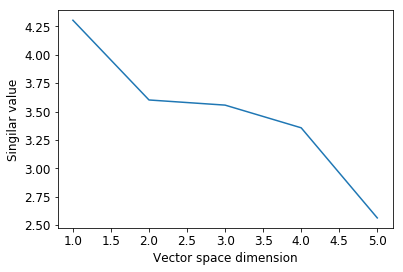

In [24]:
vdf, sv, res4 = wps2vec(wps, path, tmpath, dim)
print('Singular values:', ', '.join(str(round(x,2)) for x in sv))
plt.plot(range(1,len(sv)+1), sv)
plt.xlabel('Vector space dimension')
plt.ylabel('Singilar value')
plt.show()

The 5th dimension looks less important. We can create a 4-dim wordspace or use all the 5 axes.

In [25]:
# Create less-dimension word vector space?
# vdf, sv, res4 = wps2vec(wps, path, tmpath, dim=4)
log.update(res4)
vdf.applymap(round3).sort_values(by=[1,2,3], ascending=[False,False,False])

,word,1,2,3,4,5
1,eagle,0.891,0.0,0.000,0.455,0.000
7,herring,0.891,0.0,0.000,0.455,0.000
9,parrot,0.891,0.0,0.000,0.455,0.000
11,tuna,0.891,0.0,0.000,0.455,0.000
4,fin,0.832,0.0,0.000,-0.554,0.000
12,wing,0.832,0.0,0.000,-0.554,0.000
3,feather,0.370,0.0,0.000,-0.929,0.000
10,scale,0.370,0.0,0.000,-0.929,0.000
0,bird,0.000,1.0,0.000,0.000,0.000
2,extremity,0.000,1.0,0.000,0.000,0.000


The words are sorted descending by axes 1,2,3. One can see 4 "natural" noun clusters with the same values for axes 1 and 2.

Silhouette index in a range of cluster numbers


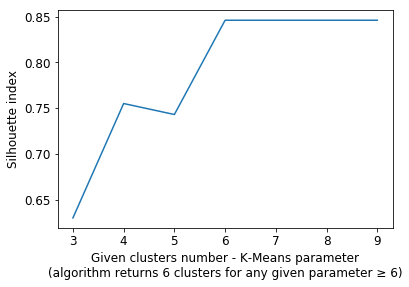

N,NR,Silhouette,Inertia,Cluster words
3,3,0.63,3.092,bird extremity fish has isa || feather fin scale wing || eagle herring parrot tuna
4,4,0.755,1.2,has isa || bird extremity fish || feather fin scale wing || eagle herring parrot tuna
5,5,0.743,0.354,has || isa || bird extremity fish || feather fin scale wing || eagle herring parrot tuna
6,6,0.846,0.0,isa || has || bird extremity fish || feather scale || fin wing || eagle herring parrot tuna
7,6,0.846,0.0,has || isa || bird extremity fish || feather scale || fin wing || eagle herring parrot tuna
8,6,0.846,0.0,has || isa || bird extremity fish || feather scale || fin wing || eagle herring parrot tuna
9,6,0.846,0.0,isa || has || bird extremity fish || feather scale || fin wing || eagle herring parrot tuna


In [26]:
# Find optimal number of clusters: max Silhouette index
sil_range = pd.DataFrame(
    columns=['Np','Nc','Silhouette','Inertia', 'Cluster words'])
table = [['N', 'NR', 'Silhouette', 'Inertia', 'Cluster words']]
for i,j in enumerate(range(3,10)):
    cdf, silhouette, inertia = cluster_words_kmeans(vdf, j)
    sil_range.loc[i] = [j, len(cdf), round(silhouette,3), \
        round(inertia,3), cdf['cluster_words'].tolist()]
    table.append([j, len(cdf), round(silhouette,3), round(inertia,3), \
        ' || '.join(' '.join(str(word) for word in cluster) \
                    for cluster in cdf['cluster_words'].tolist())])
sil_range[['Np','Nc']] = sil_range[['Np','Nc']].astype(int)
print('Silhouette index in a range of cluster numbers')
plt.plot(sil_range['Np'], sil_range['Silhouette'])
plt.xlabel('Given clusters number - K-Means parameter\n' + \
           '(algorithm returns 6 clusters for any given parameter ≥ 6)')
plt.ylabel('Silhouette index')
plt.show()
display(html_table(table))

In [27]:
n = 6  # Number of clusters
clusters, silhouette, inertia = cluster_words_kmeans(vdf, n)
clusters.applymap(round3)

,cluster,cluster_words,1,2,3,4,5
1,C01,[has],0.000,0.0,0.853,0.000,0.522
2,C02,[isa],0.000,0.0,0.647,0.000,-0.762
3,C03,"[bird, extremity, fish]",0.000,1.0,0.000,0.000,0.000
4,C04,"[feather, scale]",0.370,0.0,0.000,-0.929,0.000
5,C05,"[fin, wing]",0.832,0.0,0.000,-0.554,0.000
6,C06,"[eagle, herring, parrot, tuna]",0.891,0.0,0.000,0.455,0.000


Cluster words in vector space, axes 1 and 2


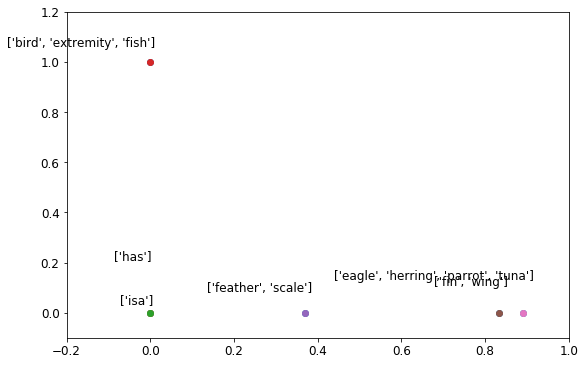

In [28]:
plot2d(1, 2, clusters, 'cluster_words', 12)

Cluster words in vector space, axes 1 and 3


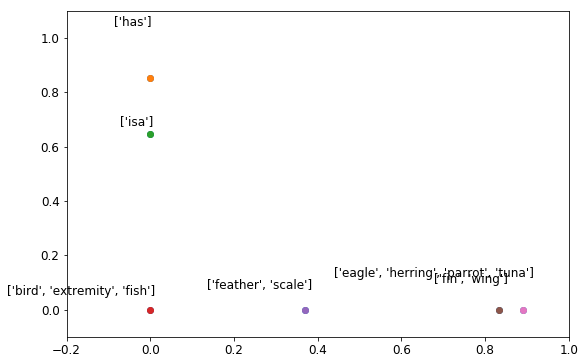

In [29]:
plot2d(1, 3, clusters, 'cluster_words', 12)

Cluster similarities: absolute values > 0.01:


,c1,c2,similarity,c1_words,c2_words
12,C04,C05,0.822935,"[feather, scale]","[fin, wing]"
14,C05,C06,0.489187,"[fin, wing]","[eagle, herring, parrot, tuna]"
0,C01,C02,0.154153,[has],[isa]


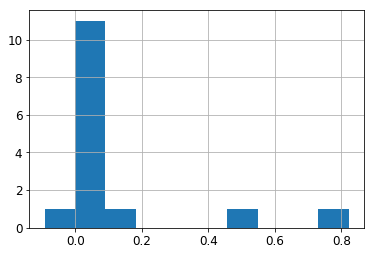

In [30]:
sim_df, res5 = cluster_similarity(clusters, 'max')
log.update(res5)
count, division = np.histogram(sim_df['similarity'])
sim_df['similarity'].hist(bins=division)
print('Cluster similarities: absolute values > 0.01:')
sim_df.sort_values(by='similarity', ascending=False).loc[(sim_df['similarity']) > 0.01]

In [31]:
from src.link_grammar.turtle import merged_clusters_grammar
lg[6] = merged_clusters_grammar(1.0, 6, clusters, sim_df, wps, path)

6 word categories (merged word clusters):


Category,Category words
C61,['has']
C62,['isa']
C63,"['bird', 'extremity', 'fish']"
C64,"['feather', 'scale']"
C65,"['fin', 'wing']"
C66,"['eagle', 'herring', 'parrot', 'tuna']"


6 Link Grammar rules:


Category,Words,Left disjuncts,Right disjuncts,Stalks
C61,['has'],"['C65C61-', 'C66C61-']","['C61C64+', 'C61C65+']",[]
C62,['isa'],"['C65C62-', 'C66C62-']",['C62C63+'],[]
C63,"['fish', 'bird', 'extremity']",['C62C63-'],[],[]
C64,"['scale', 'feather']",['C61C64-'],[],[]
C65,"['wing', 'fin']",['C61C65-'],"['C65C61+', 'C65C62+']",[]
C66,"['tuna', 'herring', 'parrot', 'eagle']",[],"['C66C61+', 'C66C62+']",[]


6 word clusters, 6 Link Grammar rules.
Link Grammar file saved to: /home/obaskov/language-learning/output/Turtle-4-2018-03-14/poc-turtle_6C_2018-03-15_0007.4.0.dict


**The learned dictionary was tested with Link Grammar parser. All the 12 "Turtle corpus" sentences were successfully parsed**:

```
tuna isa fish.

  +C66C61+C61C63+    
  |      |      |    
tuna    isa   fish [.] 


herring isa fish.

   +C66C61+C61C63+    
   |      |      |    
herring  isa   fish [.] 


tuna has fin.

  +C66C62+C62C65+    
  |      |      |    
tuna    has    fin [.] 


herring has fin.

   +C66C62+C62C65+    
   |      |      |    
herring  has    fin [.] 


parrot isa bird.

   +C66C61+C61C63+    
   |      |      |    
parrot   isa   bird [.] 


eagle isa bird.

  +C66C61+C61C63+    
  |      |      |    
eagle   isa   bird [.] 


parrot has wing.

   +C66C62+C62C65+    
   |      |      |    
parrot   has   wing [.] 


eagle has wing.

  +C66C62+C62C65+    
  |      |      |    
eagle   has   wing [.] 


fin isa extremity.

 +C65C61+C61C63+       
 |      |      |       
fin    isa extremity [.] 


wing isa extremity.

  +C65C61+C61C63+       
  |      |      |       
wing    isa extremity [.] 


fin has scale.

 +C65C62+C62C64+     
 |      |      |     
fin    has   scale [.] 


wing has feather.

  +C65C62+C62C64+      
  |      |      |      
wing    has  feather [.] 
```

### TL;DR:
We have demonstrated the possibility of unsupervised Link Grammar learning by studying links between word clusters. Section 4.3.1 shows a viable Link Grammar dictionary  consisiting of 8 rules for 8 word clusters (including separate word clusters for ###LEFT-WALL### and ".") tested by Link Grammar parser.

We have also checked the idea of learning generalised grammar rules with aggregated word clusters. The most promising result described in section 4.3.2 provided a compact grammar using 2 clusters of words - nouns and verbs, obatained in an unsupervised manner. The 4 learned rules described the complete Turtle Link Grammar and suggested structuring the single noun category (C21) into 3 sub-categories, thus learning their grammar usage specifics.

Link Grammar files are shared via [http://88.99.210.144/data/clustering_2018/POC-Turtle-4-2018-03-14/](http://88.99.210.144/data/clustering_2018/POC-Turtle-4-2018-03-14/)